<a href="https://colab.research.google.com/github/abhinavkk/CookingLLM/blob/main/LlamaIndex_%2B_DallE3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [ ]:
! pip install deepgram-sdk==2.12.0 requests ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
from deepgram import Deepgram
import asyncio, json, os


dg_key = '9c81764b32913587603ae85a1cacc8293ac88cca'
dg = Deepgram(dg_key)

'''
The most common audio formats and encodings we support
include MP3, MP4, MP2, AAC, WAV, FLAC, PCM, M4A, Ogg, Opus, and WebM,
So feel free to adjust the `MIMETYPE` variable as needed
'''
MIMETYPE = 'mp3'

#Note: You can use '.' if your audio is in the root
DIRECTORY = 'mp3'


# Feel free to modify your model's parameters as you wish!
options = {
   "punctuate": True,
   "model": 'general',
   "tier": 'enhanced'
}


#This function is what calls on the model to transcribe
def main():
   audio_folder = os.listdir(DIRECTORY)
   for audio_file in audio_folder:
       if audio_file.endswith(MIMETYPE):
         with open(f"./mp3/{audio_file}", "rb") as f:
             source = {"buffer": f, "mimetype":'audio/'+MIMETYPE}
             res = dg.transcription.sync_prerecorded(source, options)
             with open(f"./data/{audio_file[:-4]}.json", "w") as transcript:
                 json.dump(res, transcript)
   return


main()

In [ ]:
# Set this variable to the path of the output file you wish to rad
DIRECTORY = 'data/transcription'

# The JSON is loaded with information, but if you just want to read the
# transcript, run the code below!
def print_transcript(transcription_file):
 output = ""
 with open(f"data/transcription/{transcription_file}", "r") as file:
       data = json.load(file)
       result = data['results']['channels'][0]['alternatives'][0]['transcript']
       result = result.split('.')
       for sentence in result:
      #    print(sentence + '.')
          output += sentence + "\n"
      #  print(output)
       with open(f"data/{transcription_file[:-5]}.txt", "w") as f:
          f.write(output)

files = os.listdir(DIRECTORY)
for file in files:
  print_transcript(file)

# Multi-Modal RAG

In [ ]:
!pip install llama-index 'google-generativeai>=0.3.0' matplotlib qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.3/206.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0hx4yn5_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0hx4yn5_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=9c60b29e965190aebcb9c24c1cf4a1c8efd5c3a45332f9c1fc7f8aa6fa27b8c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xvek83qd/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import os
import openai
from google.colab import userdata
import google.generativeai as genai
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext, ServiceContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

from llama_index.embeddings import GeminiEmbedding
from llama_index.llms import Gemini
import matplotlib.pyplot as plt
from skimage import io


openai.api_key = userdata.get('OPENAI_API_KEY')
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Generate Image

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

### Gemini Multi-Modal

In [ ]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_gemini_3_updated")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
    )

image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
    )

# Using the embedding model to Gemini
embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)

service_context = ServiceContext.from_defaults(
    llm=Gemini(api_key=GOOGLE_API_KEY), embed_model=embed_model, chunk_size=500
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

documents = SimpleDirectoryReader("./data/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    service_context=service_context,
    storage_context=storage_context,
)

In [ ]:
query_engine = index.as_query_engine(
    similarity_top_k=1,
    # chat_mode="context"
)

response = query_engine.query(
    "How to make classic chicken roast?"
)
print(response)

The context information does not provide a specific recipe for classic chicken roast, but it does mention that the chicken is roasted with natural juice and served with a wild crust and watercress soup. It also mentions the presentation of the chicken with the bone back on top and the legs arranged nicely.


### CLIP + Retriever

In [ ]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(":memory:")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
documents = SimpleDirectoryReader("./data/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 62.1MiB/s]


**Node ID:** cf72d4df-b0f1-43e4-b58b-64d097b4330b<br>**Similarity:** 0.8693719545121289<br>**Text:** {"metadata": {"transaction_key": "deprecated", "request_id": "0a4ae15f-589b-415c-8415-3aa6901980de", "sha256": "7ed1879b3848fbcda631acaf398fe4e40219ad355de8c3cfab7d06efd0c36abf", "created": "2024-02-11T05:20:26.139Z", "duration": 648.33307, "channels": 1, "models": ["c7226e9e-ae1c-4057-ae2a-a71a6b0dc588"], "model_info": {"c7226e9e-ae1c-4057-ae2a-a71a6b0dc588": {"name": "general-enhanced", "version": "2022-05-18.1", "arch": "polaris"}}}, "results": {"channels": [{"alternatives": [{"transcript": "Hi. I'm Jack Peppa, and I'm cooking at home. I wanna show you a very simple very straightforward roasted chicken. Simple. I have a beautiful chicken here. Three pound, three three and a half pound. The first thing that I do when I wrote it, I removed the wishbone. The wishbone here that you have On each side, there you can't fill it. You cut on each side, then after with your hand, your finger, yeah, just push it forward to get to the end of it. Then put your finger on the back of it, your thumb on the back of it and bring it back down, you know. So this is that wishbone here, which is really here, and it happened in the neck. Textually when you do the carving in the dining room within the way, so I already remove it. Same thing with Turkey, duck for that matter. Make sure that when you buy it, you have ended you have a bit of a skin here, the wing I can bring in the back like this, and I can cook it this way, although I tend to like to truss it so that it holds a better shape. And what I use here, it's butcher twine, you know, don't use something in plastic. There is about five different way of trust with a trussing needle and so forth. This is without needle. And it's relatively simple. I go and do this like this and you cross above. Then here you go under the drumstick and close it and put it on the side here, turn it around and bringing behind behind the the wing to accurate. You do always do a couple two of return like this because when you tighten it, it doesn't open...<br>

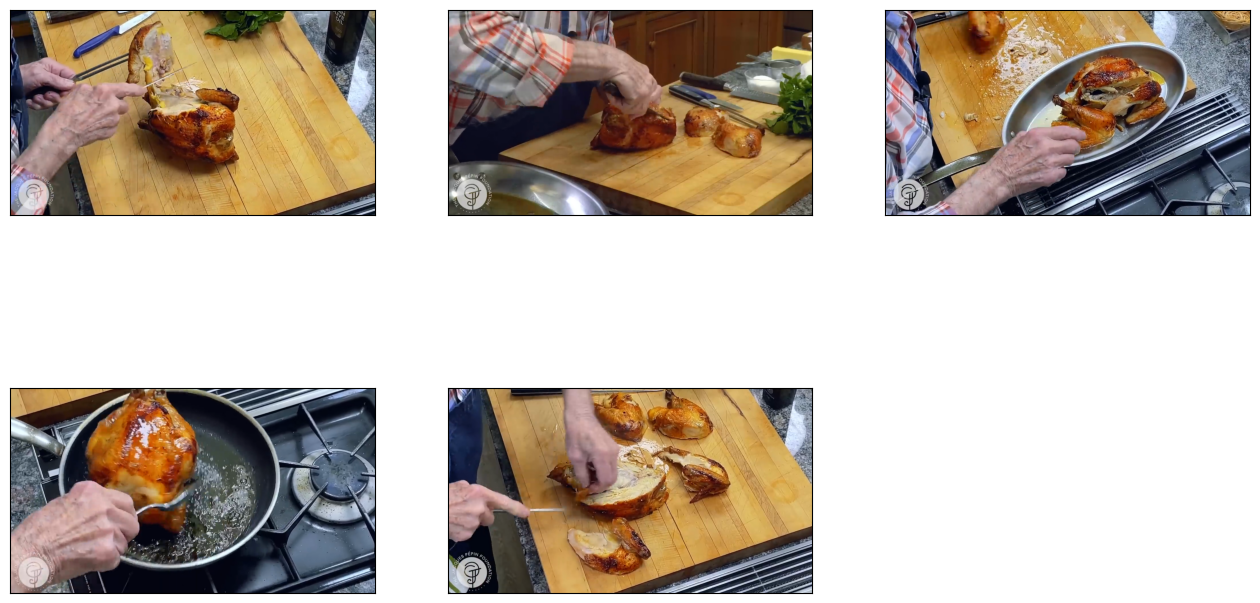

In [ ]:
from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

test_query = "How to make classic chicken roast?"
# generate  retrieval results
retriever = index.as_retriever(similarity_top_k=1, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)
# query_engine = index.as_chat_engine()

retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=2000)

plot_images(retrieved_image)

### FINAL SOLUTION - Conversational AI
#### OPEN AI + DALL_E 3




In [ ]:
def generate_dalle3_image(prompt, size="1024x1024", quality="standard", n=1):
  """
  Generates an image using DALL-E 3 via the OpenAI API.

  Args:
    prompt (str): The text description for the image.
    size (str, optional): Output image size. Defaults to "1024x1024".
    quality (str, optional): Image quality. Defaults to "standard".
    n (int, optional): Number of images to generate. Defaults to 1.

  Returns:
    list: A list of image URLs or data if response_format is set to "json".
  """

  # Specify response format: "url" for URLs, "json" for image data
  response_format = "url"

  try:
    response = openai.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size=size,
        quality=quality,
        n=n,
        response_format=response_format
    )

    if response_format == "url":
      return response.data
    else:
      return [image.url for image in response.data]

  except openai.OpenAIError as e:
    print(f"Error generating image: {e}")
    return None

def show_image(images):
  if images:
    # print(f"Generated image URLs: {images}")
    img = io.imread(images[0].url)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
  else:
    print("Failed to generate images.")


In [ ]:
service_context = ServiceContext.from_defaults(chunk_size=1000)
documents = SimpleDirectoryReader("data/txt").load_data()
index = VectorStoreIndex.from_documents(
    documents, service_context=service_context
)
query_engine = index.as_chat_engine(chat_mode="context")

def interact(text):
  response = query_engine.chat(text)
  bullets = response.response.split("\n")

  for bullet in bullets:
    print(bullet)
    if len(bullet)>0 and bullet[0] in "0123456789":
      prompt = bullet
      images = generate_dalle3_image(prompt)
      show_image(images)

To cook roasted chicken, follow these steps:

1. Preheat your oven to 425 degrees Fahrenheit (220 degrees Celsius).


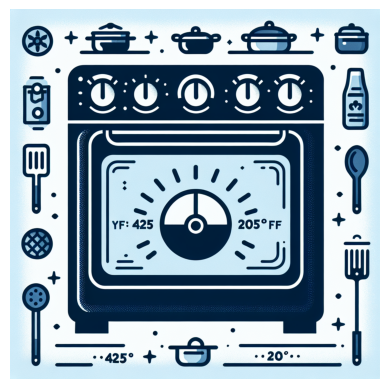


2. Remove the wishbone from the chicken. Cut on each side of the wishbone and push it forward to the end. Then, put your finger on the back of it and bring it back down. This step is optional but helps with carving later.
Error generating image: Error code: 400 - {'error': {'code': 'content_policy_violation', 'message': 'This request has been blocked by our content filters.', 'param': None, 'type': 'invalid_request_error'}}
Failed to generate images.

3. Truss the chicken to hold its shape. Use butcher twine to tie the legs and wings close to the body. Cross the twine above the chicken, go under the drumstick, and bring it behind the wing to secure. Repeat this process a couple of times to ensure it doesn't open.
Error generating image: Error code: 400 - {'error': {'code': 'content_policy_violation', 'message': 'This request has been blocked by our content filters.', 'param': None, 'type': 'invalid_request_error'}}
Failed to generate images.

4. Rub a tablespoon of butter on the chick

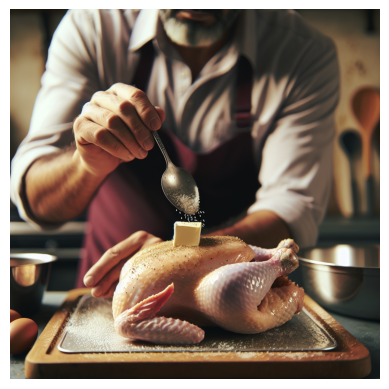


5. Place the chicken on a roasting rack in a roasting pan. Start cooking it on one side for 20 minutes, then flip it to the other side for another 20 minutes. Finally, turn it on its back and cook for another 20 minutes.


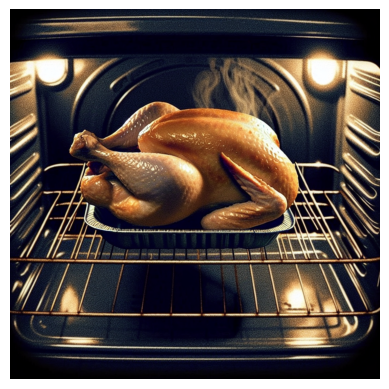


6. Check the chicken for doneness. Insert a fork into the junction between the leg and the body. If the juices run clear and the chicken is browned, it is cooked.


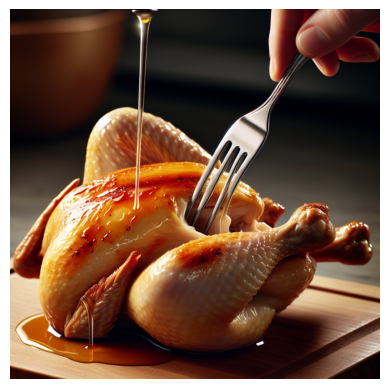


7. Remove the chicken from the oven and let it rest for a couple of minutes before carving.


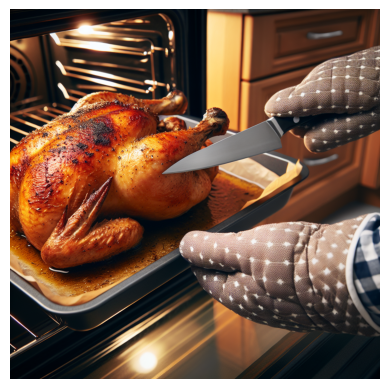


8. While the chicken rests, prepare the sauce. Remove most of the fat from the roasting pan, leaving about a tablespoon. Deglaze the pan with half a cup of chicken stock, scraping up any browned bits from the bottom. Add a dash of salt for flavor.


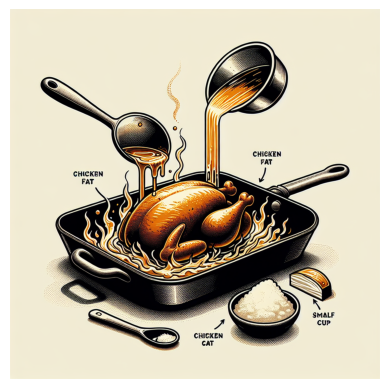


9. Thicken the sauce by adding a bit of potato starch. Dilute the starch in a little cold liquid and add it to the sauce. Stir until thickened to your desired consistency.


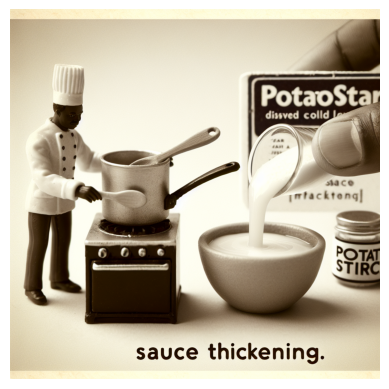


10. Carve the chicken by removing the wings, legs, and breasts. Cut along the bone to separate the pieces. Serve with the sauce and enjoy!


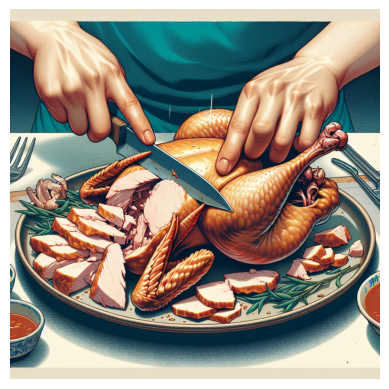


Note: These instructions are based on the context provided and may vary depending on personal preferences and cooking equipment.


In [ ]:
interact("How to cook roasted chicekn?")

To cook spinach roasted chicken, you can follow these steps:

1. Preheat your oven to 425 degrees Fahrenheit (220 degrees Celsius).


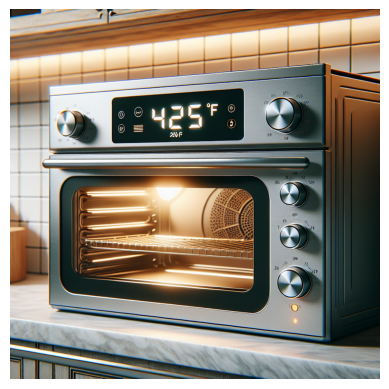


2. Prepare the spinach filling. In a skillet, heat some olive oil over medium heat. Add minced garlic and sauté until fragrant. Add fresh spinach leaves and cook until wilted. Season with salt, pepper, and any other desired herbs or spices.


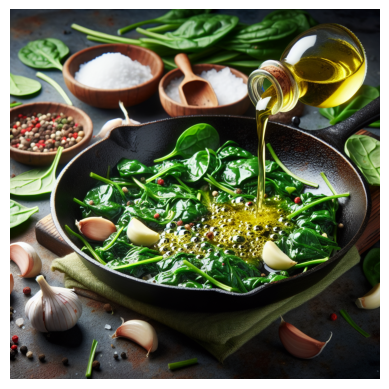


3. Butterfly the chicken. Place the chicken breast-side down on a cutting board. Using kitchen shears or a sharp knife, cut along both sides of the backbone and remove it. Flip the chicken over and press down firmly to flatten it.
Error generating image: Error code: 400 - {'error': {'code': 'content_policy_violation', 'message': 'This request has been blocked by our content filters.', 'param': None, 'type': 'invalid_request_error'}}
Failed to generate images.

4. Season the chicken. Rub the chicken with olive oil and season with salt, pepper, and any other desired herbs or spices. You can also add some lemon zest for extra flavor.


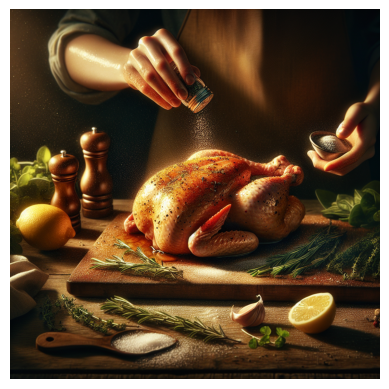


5. Stuff the chicken with the spinach filling. Spread the spinach mixture evenly over the inside of the chicken. Roll the chicken tightly and secure it with kitchen twine or toothpicks to hold it together.


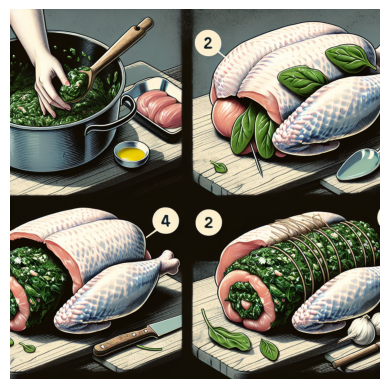


6. Place the stuffed chicken on a roasting rack in a roasting pan. Roast in the preheated oven for about 45-60 minutes, or until the internal temperature reaches 165 degrees Fahrenheit (74 degrees Celsius) and the skin is crispy and golden brown.


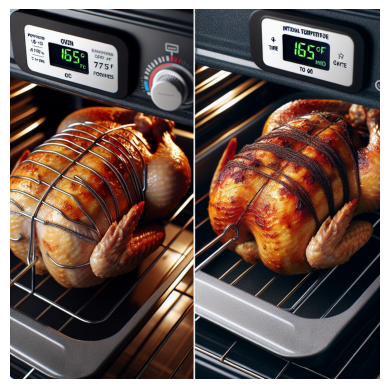


7. Remove the chicken from the oven and let it rest for a few minutes before carving. This allows the juices to redistribute and the chicken to become more tender.


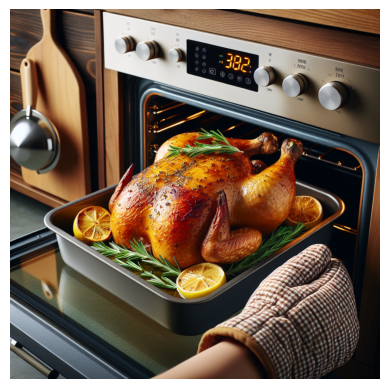


8. Carve the chicken into serving pieces and serve with the spinach filling. You can also serve it with roasted vegetables or a side salad for a complete meal.


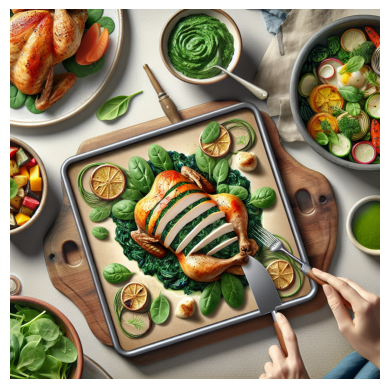


Note: Cooking times may vary depending on the size of the chicken, so it's always best to use a meat thermometer to ensure it is cooked through. Adjust the seasoning and ingredients according to your taste preferences.


In [ ]:
interact("How to cook spinach roasted chicken?")

To cook lamb chops in the style of roasted chicken, you can follow these steps:

1. Preheat your oven to 425 degrees Fahrenheit (220 degrees Celsius).


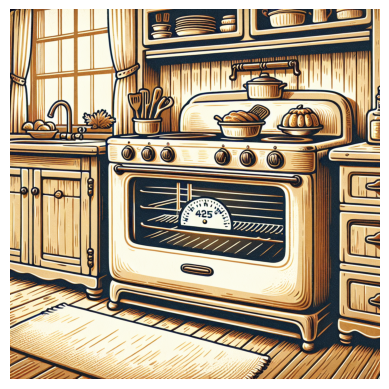


2. Season the lamb chops. Rub the lamb chops with olive oil and season them with salt, pepper, and any desired herbs or spices. You can use a combination of rosemary, thyme, garlic powder, and paprika for added flavor.


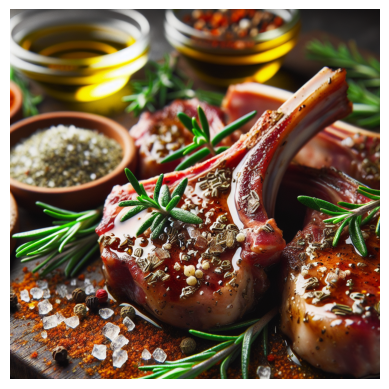


3. Heat a skillet over medium-high heat. Add a tablespoon of olive oil or butter to the skillet.


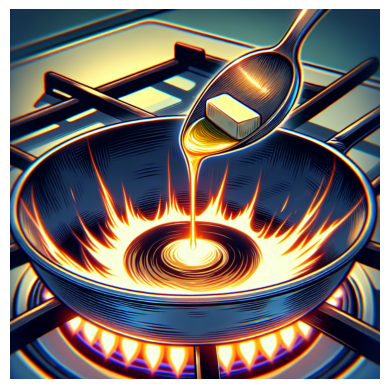


4. Sear the lamb chops. Place the lamb chops in the hot skillet and sear them for about 2-3 minutes on each side, or until they develop a golden brown crust.


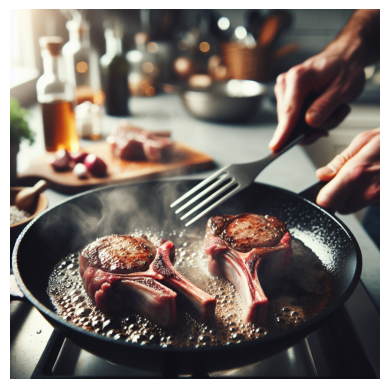


5. Transfer the seared lamb chops to a roasting pan or baking dish. Arrange them in a single layer.


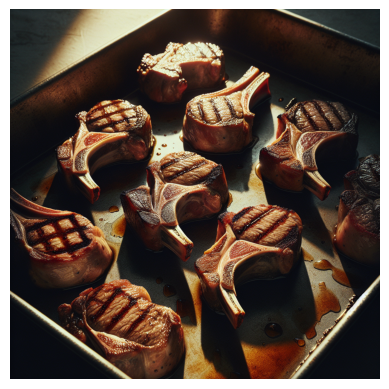


6. Roast the lamb chops in the preheated oven for about 10-15 minutes, or until they reach your desired level of doneness. For medium-rare, the internal temperature should be around 145 degrees Fahrenheit (63 degrees Celsius).


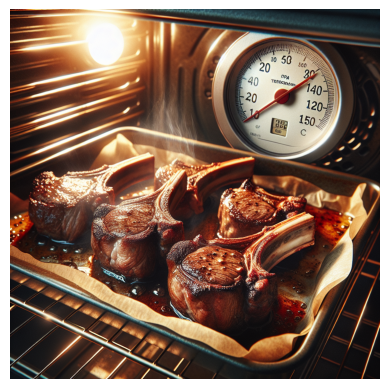


7. Remove the lamb chops from the oven and let them rest for a few minutes before serving. This allows the juices to redistribute and the lamb to become more tender.


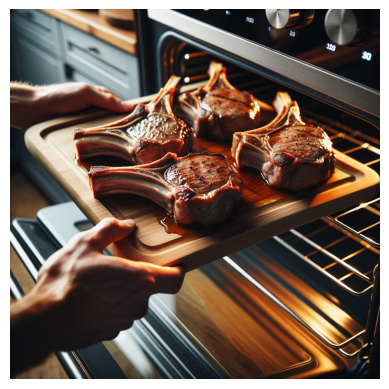


8. Serve the lamb chops with your choice of side dishes, such as roasted vegetables, mashed potatoes, or a fresh salad.


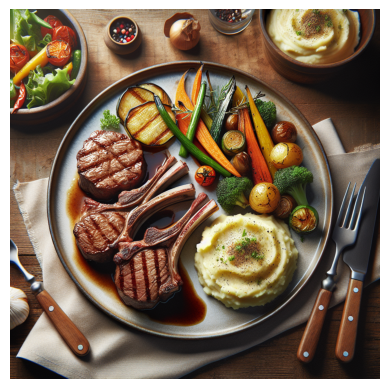


Note: Cooking times may vary depending on the thickness of the lamb chops and your desired level of doneness. It's always best to use a meat thermometer to ensure they are cooked to your preference. Adjust the seasoning and ingredients according to your taste preferences.


In [ ]:
interact("How to cook lamb chops in the style of roasted chicken?")